# Library imports

In [1]:
import pandas as pd
import matplotlib.ticker as tick
import matplotlib.pylab as plt
import seaborn as sns
from util.reformat_large_tick_values import reformat_large_tick_values as ticker

from sqlalchemy.engine import create_engine

In [2]:
engine = create_engine('bigquery://', credentials_path= 'key/iowa-liquor-sales-365322-12ff7a5498e6.json')

In [3]:
sns.set(font_scale = 1.4)
colors = ['#1f77b4', '#9467bd', '#e377c2', '#17becf', '#2ca02c', '#bcbd22', '#FFEB3B', '#FFA000', '#d62728', '#873600']
county_colors = sns.color_palette(colors)
sns.color_palette(county_colors)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (1.0, 0.9215686274509803, 0.23137254901960785),
 (1.0, 0.6274509803921569, 0.0),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5294117647058824, 0.21176470588235294, 0.0)]

# Data imports

In [4]:
census_data_df = pd.read_csv('data/census_data.csv')
census_data_df

,county,population,percent_minors
0,POLK,492401,0.245
1,LINN,230299,0.228
2,SCOTT,174669,0.235
3,JOHNSON,152854,0.197
4,BLACK HAWK,131144,0.220
5,WOODBURY,105941,0.262
6,DUBUQUE,99266,0.227
7,STORY,98537,0.164
8,DALLAS,99678,0.269
9,POTTAWATTAMIE,93667,0.234


### Adjust population to show population of 18+ adults.

In [5]:
population_over_18 = census_data_df['population']*(1-census_data_df['percent_minors'])
census_data_df['population_over_18'] = population_over_18
census_data_df['population_over_18'] = census_data_df['population_over_18'].astype(int)
census_data_df.drop(['percent_minors'], axis = 1)

,county,population,population_over_18
0,POLK,492401,371762
1,LINN,230299,177790
2,SCOTT,174669,133621
3,JOHNSON,152854,122741
4,BLACK HAWK,131144,102292
5,WOODBURY,105941,78184
6,DUBUQUE,99266,76732
7,STORY,98537,82376
8,DALLAS,99678,72864
9,POTTAWATTAMIE,93667,71748


# Compare total liters sold by county

In [6]:
county_liters_sold_sql_statement = """
WITH 
source_table AS (
  SELECT
    volume_sold_liters,
    date,
    store_number,
    county,
    EXTRACT(YEAR FROM date) AS year
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN (2018, 2019, 2020, 2021, 2022, 2023)
  ),

store_county_map AS ( 
  SELECT 
    store_number,
    MAX(county) AS county
  FROM source_table
  WHERE store_number IS NOT NULL
  GROUP BY store_number
  ),

joined_table AS (
  SELECT a.volume_sold_liters, a.date, a.year, COALESCE(a.county, b.county) AS county
  FROM source_table a
  LEFT JOIN store_county_map b ON a.store_number = b.store_number
  ),

cleaned_source_table AS (
  SELECT 
    volume_sold_liters,
    date,
    year,
    county
  FROM joined_table
  WHERE county IN ("POLK", "LINN", "SCOTT", "JOHNSON", "BLACK HAWK", "WOODBURY", "DUBUQUE", "STORY", "DALLAS", "POTTAWATTAMIE")
  )

SELECT 
    county,
    SUM(volume_sold_liters) AS liters_sold 
FROM cleaned_source_table
GROUP BY county 
ORDER BY liters_sold DESC
  """.strip()

liters_per_county_df = pd.read_sql_query(county_liters_sold_sql_statement, engine)
liters_per_county_df

/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/google/cloud/bigquery/client.py:581: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


,county,liters_sold
0,POLK,29930652.23
1,LINN,12167698.73
2,SCOTT,9396626.76
3,JOHNSON,7721792.78
4,BLACK HAWK,7397299.17
5,POTTAWATTAMIE,4919518.66
6,WOODBURY,4714513.44
7,STORY,4275882.30
8,DUBUQUE,4272910.42
9,DALLAS,3558796.90


# Combine census data with liquor sales data

In [7]:
liters_sold_and_adult_pop_df = pd.merge(liters_per_county_df, census_data_df, on= 'county')
liters_sold_and_adult_pop_df

,county,liters_sold,population,percent_minors,population_over_18
0,POLK,29930652.23,492401,0.245,371762
1,LINN,12167698.73,230299,0.228,177790
2,SCOTT,9396626.76,174669,0.235,133621
3,JOHNSON,7721792.78,152854,0.197,122741
4,BLACK HAWK,7397299.17,131144,0.220,102292
5,POTTAWATTAMIE,4919518.66,93667,0.234,71748
6,WOODBURY,4714513.44,105941,0.262,78184
7,STORY,4275882.30,98537,0.164,82376
8,DUBUQUE,4272910.42,99266,0.227,76732
9,DALLAS,3558796.90,99678,0.269,72864


In [8]:
liters_sold_and_adult_pop_df = liters_sold_and_adult_pop_df.drop(['percent_minors', 'population'], axis = 1)
liters_sold_and_adult_pop_df

,county,liters_sold,population_over_18
0,POLK,29930652.23,371762
1,LINN,12167698.73,177790
2,SCOTT,9396626.76,133621
3,JOHNSON,7721792.78,122741
4,BLACK HAWK,7397299.17,102292
5,POTTAWATTAMIE,4919518.66,71748
6,WOODBURY,4714513.44,78184
7,STORY,4275882.30,82376
8,DUBUQUE,4272910.42,76732
9,DALLAS,3558796.90,72864


# Calculate total liters sold per adult over target period using data from combined sources.

In [9]:
liters_sold_and_adult_pop_df['liters_sold_per_adult'] = liters_sold_and_adult_pop_df['liters_sold']/liters_sold_and_adult_pop_df['population_over_18']
liters_sold_per_adult_df = liters_sold_and_adult_pop_df[['county', 'liters_sold_per_adult']]
liters_sold_per_adult_df

,county,liters_sold_per_adult
0,POLK,80.510252
1,LINN,68.438600
2,SCOTT,70.322979
3,JOHNSON,62.911275
4,BLACK HAWK,72.315520
5,POTTAWATTAMIE,68.566631
6,WOODBURY,60.300233
7,STORY,51.906894
8,DUBUQUE,55.686160
9,DALLAS,48.841635


# Visual feature exploration

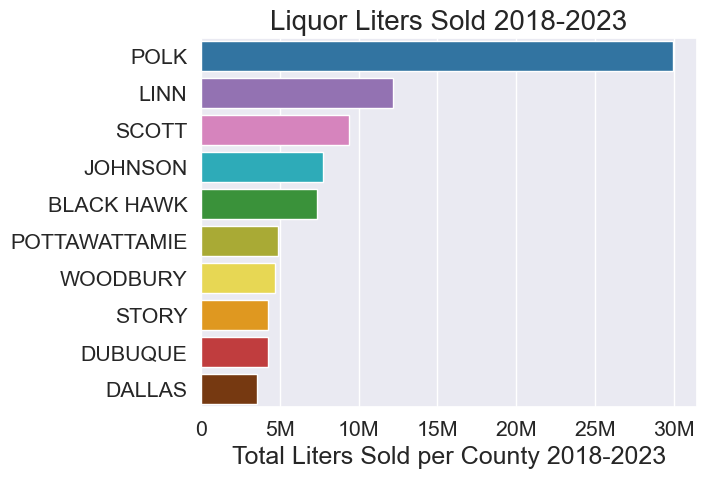

In [10]:
sns.barplot(x = 'liters_sold', y = 'county', data= liters_per_county_df,  palette= county_colors)
ax = plt.gca()
ax.set_xlabel("Total Liters Sold per County 2018-2023" , size = 18)
#ax.set_ylabel('Iowa Counties', size = 18)
ax.set_ylabel(None)
ax.set_title("Liquor Liters Sold 2018-2023", size = 20)
ax.xaxis.set_major_formatter(tick.FuncFormatter(ticker))
#sns.axes_style("ticks")
sns.set_style("whitegrid")
plt.savefig('liquor_liters_sold.png', transparent= True, bbox_inches='tight', pad_inches=0)

## Polk County purchases much more than other counties. It purchase more than twice the liters of Linn, the next highest consuming county, more than three time the amount of liters as Linn, Scott, Johnson and Black Hawk, and more than six times that purchased by the lower half of counties.  

Use Iowa liquor sales data to visualize total sales per county per year over target six year period.

In [11]:
sales_by_county_year_sql_statement = """
WITH 
source_table AS (
  SELECT
    volume_sold_liters,
    date,
    store_number,
    county,
    CAST(EXTRACT(YEAR FROM date) AS string) AS year
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN (2018, 2019, 2020, 2021, 2022, 2023)
  ),

store_county_map AS ( 
  SELECT 
    store_number,
    MAX(county) AS county
  FROM source_table
  WHERE store_number IS NOT NULL
  GROUP BY store_number
  ),

joined_table AS (
  SELECT a.volume_sold_liters, a.date, a.year, COALESCE(a.county, b.county) AS county
  FROM source_table a
  LEFT JOIN store_county_map b ON a.store_number = b.store_number
  ),

cleaned_source_table AS (
  SELECT 
    volume_sold_liters,
    date,
    year,
    county
  FROM joined_table
  WHERE county IN ("POLK", "LINN", "SCOTT", "JOHNSON", "BLACK HAWK", "WOODBURY", "DUBUQUE", "STORY", "DALLAS", "POTTAWATTAMIE")
  )

SELECT
    sum(volume_sold_liters) AS liters_sold,
    year,
    county
FROM cleaned_source_table
GROUP BY county, year 
ORDER BY year
""" .strip()

sales_by_county_year_df = pd.read_sql_query(sales_by_county_year_sql_statement, engine)

In [12]:
sales_by_county_year_df['county'] = sales_by_county_year_df['county'].str.title()

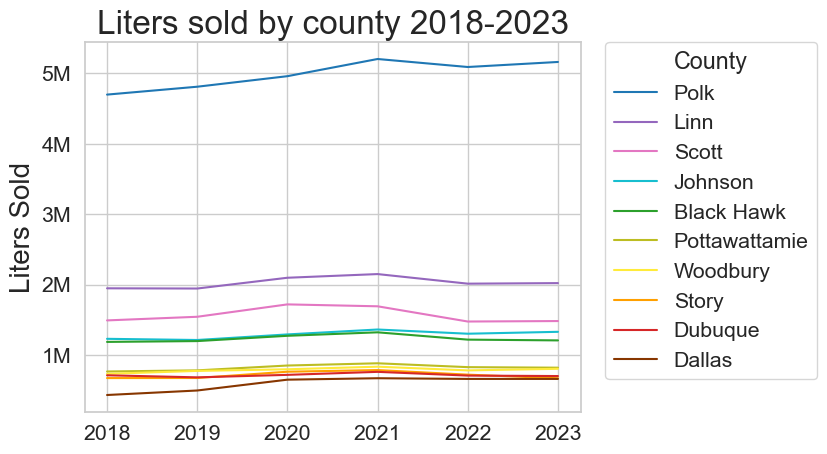

In [13]:
sns.lineplot(data = sales_by_county_year_df, x = 'year', y = 'liters_sold', hue= 'county', palette= county_colors,
hue_order = [
    "Polk","Linn","Scott","Johnson","Black Hawk","Pottawattamie","Woodbury","Story","Dubuque","Dallas"
         ])
ax  = plt.gca()
ax.set(xlabel=None)
ax.set_ylabel( "Liters Sold" , size = 20 )
ax.set_title( "Liters sold by county 2018-2023", size = 24 )
ax.yaxis.set_major_formatter(tick.FuncFormatter(ticker))
plt.legend(title = 'County', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

## Use Iowa liquor sales data to calculate percent change per year over target four year period. Data from 2017 used to establish percent change for 2018. 

Percent change calculated as ((liters_sold_county - prev_liters_sold_county)/prev_liters_sold_county)*100

In [14]:
percent_change_county_sql_query = """
WITH 
source_table AS (
  SELECT
    volume_sold_liters,
    date,
    store_number,
    county,
    CAST(EXTRACT(YEAR FROM date) AS string) AS year
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN (2017, 2018, 2019, 2020, 2021, 2022, 2023)
  ),

store_county_map AS ( 
  SELECT 
    store_number,
    MAX(county) AS county
  FROM source_table
  WHERE store_number IS NOT NULL
  GROUP BY store_number
  ),

joined_table AS (
  SELECT a.volume_sold_liters, a.date, a.year, COALESCE(a.county, b.county) AS county
  FROM source_table a
  LEFT JOIN store_county_map b ON a.store_number = b.store_number
  ),

cleaned_source_table AS (
  SELECT 
    volume_sold_liters,
    date,
    year,
    county
  FROM joined_table
  WHERE county IN ("POLK", "LINN", "SCOTT", "JOHNSON", "BLACK HAWK", "WOODBURY", "DUBUQUE", "STORY", "DALLAS", "POTTAWATTAMIE")
  ),

liters_county_sum AS (
  SELECT 
     SUM(volume_sold_liters) as liters_sold_county,
     year,
     county
  FROM cleaned_source_table
  GROUP BY year, county
  ),
  
lag_year AS(
  SELECT
      county,
      year,
      liters_sold_county,
      LAG(liters_sold_county) OVER(PARTITION BY county ORDER BY year) AS prev_liters_sold_county
  FROM liters_county_sum
  ),

percent_change_per_year AS (
  SELECT  
     county,
     year,
     ROUND(((liters_sold_county - prev_liters_sold_county)/prev_liters_sold_county)*100) AS percent_change_year
  FROM lag_year)

  SELECT
        *
  FROM percent_change_per_year
  ORDER BY year, county
""" .strip()

percent_change_county = pd.read_sql_query(percent_change_county_sql_query, engine)
percent_change_county['county'] = percent_change_county['county'].str.title()

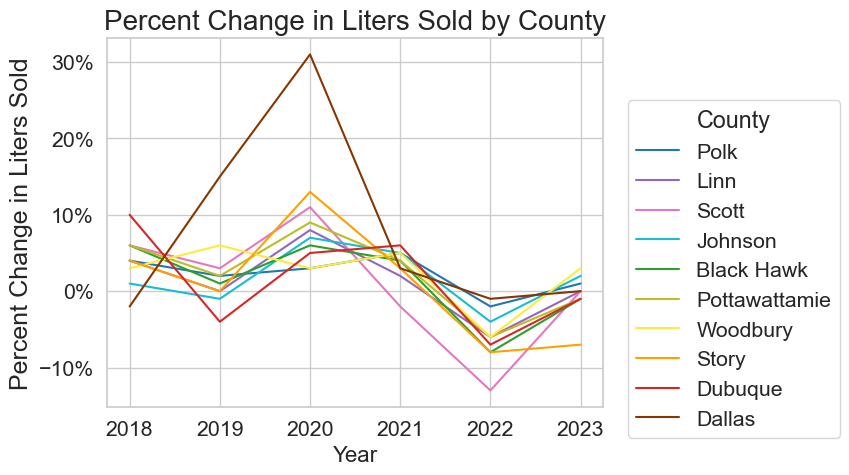

In [15]:
sns.lineplot(data = percent_change_county, x = 'year', y = 'percent_change_year', hue= 'county',  palette= county_colors,
            hue_order = [
    "Polk","Linn","Scott","Johnson","Black Hawk","Pottawattamie","Woodbury","Story","Dubuque","Dallas"
         ])
ax= plt.gca()
ax.set_xlabel("Year", size = 16 )
ax.set_ylabel( "Percent Change in Liters Sold" , size = 18 )
ax.set_title( "Percent Change in Liters Sold by County", size = 20 )
ax.yaxis.set_major_formatter(tick.PercentFormatter(decimals = 0))
plt.legend(title = 'County', bbox_to_anchor=(1.05, .83), loc='upper left', borderaxespad=0)
plt.show()

We see a decrease in consumption from 2018 to 2019. Purchases increase  increase in 

In [16]:
liters_county_sum_sql_query = """
WITH 
source_table AS (
  SELECT
    volume_sold_liters,
    #date,
    store_number,
    county,
    CAST(EXTRACT(YEAR FROM date) AS string) AS year,
    CAST(EXTRACT(MONTH FROM date) AS string) AS month
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN ( 2018, 2019, 2020, 2021, 2022, 2023)
  ),

store_county_map AS ( 
  SELECT 
    store_number,
    MAX(county) AS county
  FROM source_table
  WHERE store_number IS NOT NULL
  GROUP BY store_number
  ),

joined_table AS (
  SELECT a.volume_sold_liters, #a.date, 
          a.month, a.year, COALESCE(a.county, b.county) AS county
  FROM source_table a
  LEFT JOIN store_county_map b ON a.store_number = b.store_number
  ),

cleaned_source_table AS (
  SELECT 
    volume_sold_liters,
    #date,
    month,
    year,
    county
  FROM joined_table
  WHERE county IN ("POLK", "LINN", "SCOTT", "JOHNSON", "BLACK HAWK", "WOODBURY", "DUBUQUE", "STORY", "DALLAS", "POTTAWATTAMIE")
  ),

liters_county_sum AS (
  SELECT 
     SUM(volume_sold_liters) as liters_sold_county,
     #date,
     month,
     year,
     county
  FROM cleaned_source_table
  GROUP BY month, year, county
  )

  SELECT
        *
  FROM liters_county_sum
  ORDER BY month, year, county

""" .strip()

liters_county_sum_df = pd.read_sql_query(liters_county_sum_sql_query, engine)
#lag_month['county'] = percent_change_county['county'].str.title()
liters_county_sum_df


,liters_sold_county,month,year,county
0,90066.28,1,2018,BLACK HAWK
1,17174.02,1,2018,DALLAS
2,54963.05,1,2018,DUBUQUE
3,92307.21,1,2018,JOHNSON
4,135373.16,1,2018,LINN
...,...,...,...,...
715,403372.18,9,2023,POLK
716,69719.35,9,2023,POTTAWATTAMIE
717,106780.96,9,2023,SCOTT
718,54102.59,9,2023,STORY


In [17]:
liters_county_sum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   liters_sold_county  720 non-null    float64
 1   month               720 non-null    object 
 2   year                720 non-null    object 
 3   county              720 non-null    object 
dtypes: float64(1), object(3)
memory usage: 22.6+ KB


In [18]:
liters_county_sum_df['year'] = liters_county_sum_df['year'].astype(str)
liters_county_sum_df['month'] = liters_county_sum_df['month'].astype(str)

# Combine 'year' and 'month' into a single 'date' column formatted as 'YYYY-MM'
liters_county_sum_df['date'] = pd.to_datetime(liters_county_sum_df['year'] + '-' + liters_county_sum_df['month'])
liters_county_sum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   liters_sold_county  720 non-null    float64       
 1   month               720 non-null    object        
 2   year                720 non-null    object        
 3   county              720 non-null    object        
 4   date                720 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 28.2+ KB


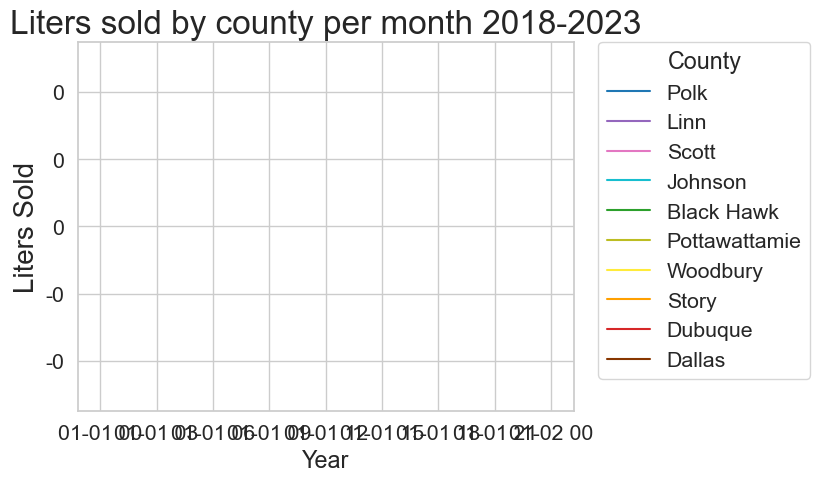

In [40]:
hue_order = ["Polk","Linn","Scott","Johnson","Black Hawk","Pottawattamie","Woodbury","Story","Dubuque","Dallas"]
hue_order_upper = [county.upper() for county in hue_order]

sns.lineplot(data = liters_county_sum_df, x = 'date', y = 'liters_sold_county', hue= 'county',  
#hue_order = hue_order_upper, 
palette= county_colors)

        
ax  = plt.gca()
ax.set(xlabel= 'Year')
ax.set_ylabel( "Liters Sold" , size = 20 )
ax.set_title( "Liters sold by county per month 2018-2023", size = 24 )
ax.yaxis.set_major_formatter(tick.FuncFormatter(ticker))
plt.legend(title = 'County', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()